In [185]:
import time
import os
import urllib.parse

import numpy as np
import tensorflow as tf
from tensorflow.core.example.example_pb2 import Example
from tensorflow.core.example.feature_pb2 import Feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)


1.12.0


# Get data
We are using the Census data. We are proposing a process to assess algorithmic bias in models, so instead of using the classification for whether people have >50k income, it will be used to classify if people should get a loan.

In [186]:
DOWNLOAD = False

csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

input_features = ["age", "workclass", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]

categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

label_column = 'loan'

csv_path = "data/adult.csv"

if DOWNLOAD:
    csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

# X,y = shap.datasets.adult()
# df = X
# df.columns = ["age", "workclass", "education-num", "marital-status",
#                    "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
#                    "hours-per-week", "native-country"]
# df[label_column] = y



# Delete unused column
# del df["fnlwgt"] 

X_display = df.drop(label_column, axis=1)
y_display = df[label_column]

# Normalising to increase accuracy
dtypes = list(zip(df.dtypes.index, map(str, df.dtypes)))
for k,dtype in dtypes:
    if dtype == "int64":
        df[k] = df[k].astype('float64')
        df[k] -= df[k].mean()
        df[k] /= df[k].std()    
        
df[label_column] = df[label_column].apply(lambda x:  x in [">50K", ">50K."]).astype(int)
# df[label_column] = df[label_column].astype(int)
    
# cat_columns = df.select_dtypes(['object']).columns
# df[cat_columns] = df[cat_columns].astype('category')
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

# g = df.groupby('loan')
# df = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,0.025996,State-gov,-1.061968,Bachelors,1.136500,Never-married,Adm-clerical,Not-in-family,White,Male,0.146931,-0.217125,-0.034087,United-States,0
1,0.828300,Self-emp-not-inc,-1.007094,Bachelors,1.136500,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.144802,-0.217125,-2.213009,United-States,0
2,-0.046941,Private,0.246031,HS-grad,-0.419331,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.144802,-0.217125,-0.034087,United-States,0
3,1.047110,Private,0.426659,11th,-1.197247,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.144802,-0.217125,-0.034087,United-States,0
4,-0.776309,Private,1.408515,Bachelors,1.136500,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.144802,-0.217125,-0.034087,Cuba,0


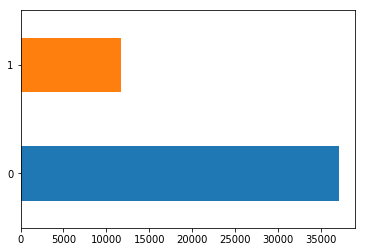

In [187]:
df[label_column].value_counts().plot.barh()

In [188]:
X = df.drop(label_column, axis=1)
y = df[label_column]

In [189]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=101)

In [190]:

# gender = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="gender", hash_bucket_size=1000, dtype=tf.int8))

# ethnicity = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="ethnicity", hash_bucket_size=1000, dtype=tf.int8))

# marital_status = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "marital-status", hash_bucket_size=100, dtype=tf.int8))

# relationship = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "relationship", hash_bucket_size=100, dtype=tf.int8))

# workclass = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "workclass", hash_bucket_size=100, dtype=tf.int8))

# occupation = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000, dtype=tf.int8))

# native_country = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000, dtype=tf.int8))

# education = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000, dtype=tf.int8))











# gender = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="gender", hash_bucket_size=5))

# ethnicity = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="ethnicity", hash_bucket_size=10))

# marital_status = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "marital-status", hash_bucket_size=10))

# relationship = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "relationship", hash_bucket_size=10))

# workclass = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "workclass", hash_bucket_size=10))

# occupation = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=20))

# native_country = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=50))

# education = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=20))







# gender = tf.feature_column.categorical_column_with_vocabulary_list("gender", ["Female", "Male"])
# occupation = tf.feature_column.categorical_column_with_hash_bucket("occupation", hash_bucket_size=1000)
# marital_status = tf.feature_column.categorical_column_with_hash_bucket("marital-status", hash_bucket_size=1000)
# relationship = tf.feature_column.categorical_column_with_hash_bucket("relationship", hash_bucket_size=1000)
# # ethnicity = tf.feature_column.categorical_column_with_hash_bucket("ethnicity", hash_bucket_size=1000)
# education = tf.feature_column.categorical_column_with_hash_bucket("education", hash_bucket_size=1000)
# workclass = tf.feature_column.categorical_column_with_hash_bucket("workclass", hash_bucket_size=1000)
# native_country = tf.feature_column.categorical_column_with_hash_bucket("native-country", hash_bucket_size=1000)




gender = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("gender", ["Female", "Male"]))
occupation = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("occupation", list(df["occupation"].astype("category").cat.categories)))
marital_status = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("marital-status", list(df["marital-status"].astype("category").cat.categories)))
relationship = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("relationship", list(df["relationship"].astype("category").cat.categories)))
ethnicity = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("ethnicity", list(df["ethnicity"].astype("category").cat.categories)))
education = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("education", list(df["education"].astype("category").cat.categories)))
workclass = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("workclass", list(df["workclass"].astype("category").cat.categories)))
native_country = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("native-country", list(df["native-country"].astype("category").cat.categories)))



# all_columns = []
# dtypes = list(zip(X_train.dtypes.index, map(str, X_train.dtypes)))
# for k,dtype in dtypes:
#     print(k)
#     if dtype == "int8":
#         all_columns.append(
#             tf.feature_column.embedding_column(
#                 tf.feature_column.categorical_column_with_hash_bucket(
#                     k, hash_bucket_size=X[k].max()+1, dtype=tf.int8
#                 ),
#                 dimension=8
#             )
#         )
#     else:
#         all_columns.append(
#             tf.feature_column.numeric_column(k)
#         )


# occupation = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000),
#         dimension=8)

# native_country = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000),
#         dimension=8)

# education = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000),
#         dimension=8)

In [191]:
age = tf.feature_column.numeric_column("age")
education_num = tf.feature_column.numeric_column("education-num")
capital_gain = tf.feature_column.numeric_column("capital-gain")
capital_loss  = tf.feature_column.numeric_column("capital-loss")
hours_per_week = tf.feature_column.numeric_column("hours-per-week")

# age = tf.feature_column.bucketized_column(
#     age, boundaries=list(range(0,100,5)))
# education_num = tf.feature_column.bucketized_column(
#     education_num, boundaries=list(range(0,16,1)))
# capital_gain = tf.feature_column.bucketized_column(
#     capital_gain, boundaries=list(range(0,100000,5000)))
# capital_loss  = tf.feature_column.bucketized_column(
#     capital_loss, boundaries=list(range(0,4000,500)))
# hours_per_week = tf.feature_column.bucketized_column(
#     hours_per_week, boundaries=list(range(0,100,5)))

In [192]:
all_columns = [
    # Categorical
    gender,
    occupation,
    marital_status,
    relationship,
    ethnicity,
    education,
    workclass,
    native_country,
    
    # Numerical
    age,
    education_num,
    capital_gain,
    capital_loss,
    hours_per_week,
]

In [193]:

train_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        batch_size=512,
        num_epochs=None,
        shuffle=True)


In [194]:

# batches_per_layer=1000
# m = tf.estimator.BoostedTreesClassifier(
#     feature_columns=all_columns,
#     n_batches_per_layer=batches_per_layer,
#     n_trees=10,
#     max_depth=6,
# #     l2_regularization=1.0,
# #     l1_regularization=1.0,
#     learning_rate=0.1,
#     n_classes=2,
# )
# print(batches_per_layer)



m = tf.estimator.DNNClassifier(
#             model_dir="models/model_DEEP_" + str(int(time.time())),
            feature_columns=all_columns,
#             optimizer=lambda: tf.train.AdamOptimizer(
#                 learning_rate=tf.train.exponential_decay(
#                     learning_rate=0.1,
#                     global_step=tf.train.get_global_step(),
#                     decay_steps=10000,
#                     decay_rate=0.96)),
#             loss_reduction=tf.losses.Reduction.,
            dropout=0.5,
            hidden_units=[100, 1]
)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpp2ky_ub7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd3d4091438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [195]:
# %%time 

m.train(input_fn=train_input_fn, steps=1000)

print('training done')

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpp2ky_ub7/model.ckpt.
INFO:tensorflow:loss = 386.2033, step = 1
INFO:tensorflow:global_step/sec: 68.1569
INFO:tensorflow:loss = 278.14832, step = 101 (1.468 sec)
INFO:tensorflow:global_step/sec: 79.4418
INFO:tensorflow:loss = 254.23212, step = 201 (1.258 sec)
INFO:tensorflow:global_step/sec: 76.2886
INFO:tensorflow:loss = 255.3916, step = 301 (1.311 sec)
INFO:

In [196]:
eval_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        batch_size=40,
        num_epochs=1,
        shuffle=False)

results = m.evaluate(input_fn=eval_input_fn)

print("\n\nSTATS:\n\n")

for r in results:
    print(r, results[r])


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-04-18:11:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpp2ky_ub7/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-04-18:11:12
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8152597, accuracy_baseline = 0.7575241, auc = 0.8790488, auc_precision_recall = 0.7705258, average_loss = 0.4144461, global_step = 1000, label/mean = 0.24247594, loss = 16.547352, precision = 0.92727274, prediction/mean = 0.2530541, recall = 0.2583732
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpp2ky_ub7/model.ckpt-1000


STATS:


accuracy 0.8152597
accuracy_baseline 0.7575241
auc 0.8790488
auc_precision_recall 0.7705258
average_loss 0.4144461
label/mean 0.24247594
loss 16.547352
precision 0.92727274
prediction/

In [197]:
prediction_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=len(X_test),
        shuffle=False)

pred_gen = m.predict(input_fn=prediction_input_fn)

pred_list = []

for pred, actual in zip(pred_gen, y):
    tmp = []
    tmp.append(pred["logits"][0])   
    tmp.append(pred["logistic"][0])
    tmp.append(pred["probabilities"][0])
    tmp.append(pred["probabilities"][1])
    tmp.append(actual)
    tmp.append(pred["class_ids"][0])
    tmp.append(int(pred["class_ids"][0] == actual))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 1))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 0))

    #get index of maximum value of sigmoid. it will correspond to class
    pred_list.append(tmp)


pred_cols = ["logits", "logistic", "prob_neg", "prob_pos",
            "actual", "predicted", "is_correct", 
             "false_positive", "false_negative"]

pred_df = pd.DataFrame(pred_list, columns=pred_cols)
# pred_df

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpp2ky_ub7/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


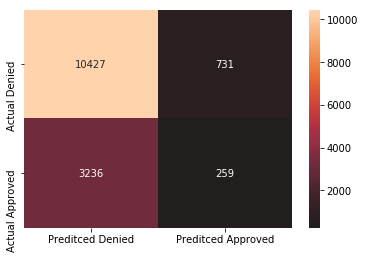

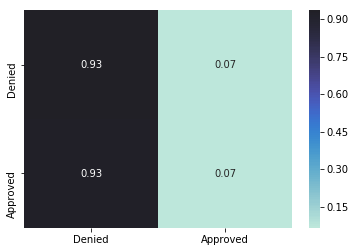

In [198]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(
    pred_df["actual"],
    pred_df["predicted"])

confusion_df = pd.DataFrame(confusion, 
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

0.5092150182025842


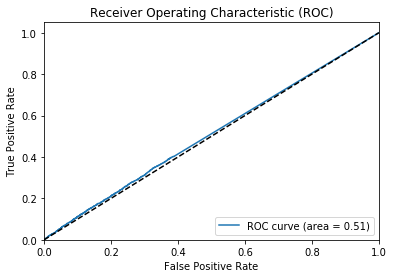

In [199]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        pred_df["actual"].values, pred_df["prob_pos"].values)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [29]:

print(classification_report(pred_df["actual"], pred_df["predicted"]))


              precision    recall  f1-score   support

           0       0.76      1.00      0.87      7447
           1       0.00      0.00      0.00      2322

   micro avg       0.76      0.76      0.76      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.58      0.76      0.66      9769



/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Data Analysis

In [ ]:
import math
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if df.dtypes[column] == np.object:
        df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
X_analysis = X_display.copy()
X_analysis = X_analysis.join(pred_df)

X_analysis.tail(5)

In [ ]:
X_display.gender.value_counts().plot.barh()

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

# Explainability with SHAP

In [ ]:
import shap
shap.initjs()


In [ ]:
tf_shap_idx = 39
tf_shap_x = X.iloc[tf_shap_idx,:]
tf_shap_display = X_display.iloc[tf_shap_idx,:]
tf_shap_y = y.iloc[tf_shap_idx]
print(tf_shap_y)

In [ ]:



def shap_predict_proba(shap_X):
    tmp_df = pd.DataFrame(data=shap_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        pred_list.append(pred["logits"][0])
    pred_arr = np.array(pred_list)

    return pred_arr

tf_explainer = shap.KernelExplainer(
                        shap_predict_proba, 
                        X.iloc[:100,:], 
                        link="identity")


In [ ]:
tf_shap_values = tf_explainer.shap_values(tf_shap_x, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values, tf_shap_display)

In [ ]:
tf_shap_idx_multi_from = 15
tf_shap_idx_multi_to = 40
tf_shap_x_multi = X.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_display_multi = X_display.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_y_multi = y.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to]
print(tf_shap_y_multi)

In [ ]:
tf_shap_values_multi = tf_explainer.shap_values(tf_shap_x_multi, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values_multi, tf_shap_display_multi)

In [ ]:
shap.dependence_plot("gender", 
                     tf_shap_values_multi, 
                     tf_shap_x_multi, 
                     display_features=tf_shap_display_multi)

In [ ]:
shap.summary_plot(tf_shap_values_multi, tf_shap_x_multi)


# Census income classification with Keras

We use keras to perform this computation


In [200]:
from sklearn.model_selection import train_test_split
import sklearn
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sn
import numpy as np
import shap
shap.initjs()

In [201]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

print(dtypes)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

[('Age', 'float32'), ('Workclass', 'int8'), ('Education-Num', 'float32'), ('Marital Status', 'int8'), ('Occupation', 'int8'), ('Relationship', 'int64'), ('Race', 'int8'), ('Sex', 'int8'), ('Capital Gain', 'float32'), ('Capital Loss', 'float32'), ('Hours per week', 'float32'), ('Country', 'int8')]


In [202]:
# Defining model as functional type

input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)

layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1, activation='sigmoid')(layer1)

# y_train_hot = keras.utils.to_categorical(y_train)
# y_valid_hot = keras.utils.to_categorical(y_valid)

# train model
model = Model(inputs=input_els, outputs=[out])
model.compile(optimizer="adam", loss='binary_crossentropy')
model.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Train on 26048 samples, validate on 6513 samples
Epoch 1/50
26048/26048 [==============================] - 2s 74us/step - loss: 0.5648 - val_loss: 0.4494
Epoch 2/50
26048/26048 [==============================] - 0s 11us/step - loss: 0.4205 - val_loss: 0.3639
Epoch 3/50
26048/26048 [==============================] - 0s 12us/step - loss: 0.3674 - val_loss: 0.3385
Epoch 4/50
26048/26048 [==============================] - 0s 10us/step - loss: 0.3476 - val_loss: 0.3300
Epoch 5/50
26048/26048 [==============================] - 0s 11us/step - loss: 0.3386 - val_loss: 0.3251
Epoch 6/50
26048/26048 [==============================] - 0s 14us/step - loss: 0.3312 - val_loss: 0.3221
Epoch 7/50
26048/26048 [==============================] - 0s 12us/step - loss: 0.3280 - val_loss: 0.3203
Epoch 8/50
26048/26048 [==============================] - 0s 12us/step - loss: 0.3250 - val_loss: 0.3190
Epoch 9/50
26048/26048 [==============================] - 0s 12us/step - loss: 0.3248 - val_loss: 0.3184
Epoch 

In [203]:
input_test = [X.iloc[:,i] for i in range(X.shape[1])]
score = model.evaluate(input_test, y, verbose=1)
# print(list(predictions.T[0]))
# ??np.argmax
print(score)

32561/32561 [==============================] - 3s 78us/step
0.30483113906808273


In [204]:
input_test = [X_valid.iloc[:,i] for i in range(X.shape[1])]
probabilities = model.predict(input_test)
print(list(probabilities.T[0])[:10])
# print(list(predictions.T[1])[:10])

[0.09658425, 0.5374395, 0.027518522, 0.01529101, 0.1924318, 0.14434837, 0.053513728, 0.42425838, 0.0004511889, 0.96873236]


In [205]:
pred = list((probabilities >= 0.5).astype(int).T[0])

In [206]:
print(sklearn.metrics.classification_report(y_valid, pred))

print("\nF1 Score:", sklearn.metrics.f1_score(y_valid, pred))

print("\nAccuracy:", sklearn.metrics.accuracy_score(y_valid, pred))

              precision    recall  f1-score   support

       False       0.88      0.93      0.91      4951
        True       0.74      0.61      0.67      1562

   micro avg       0.86      0.86      0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513


F1 Score: 0.6708683473389356

Accuracy: 0.8556732688469215


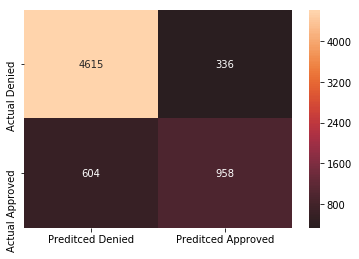

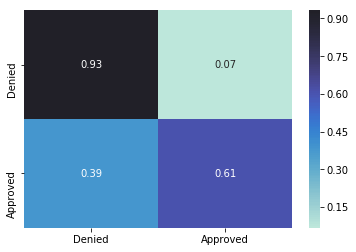

In [207]:

confusion = sklearn.metrics.confusion_matrix(
    y_valid,
    pred)


confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

0.7727255917207584


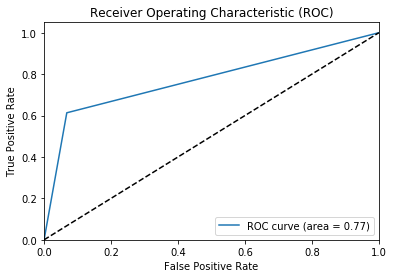

In [208]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        y_valid, pred)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [165]:
def f(X):
    values = regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values
keras_explainer = shap.KernelExplainer(f, X.iloc[:100,:])

In [178]:
keras_idx = 9
keras_x = X.iloc[keras_idx,:]
keras_y = y[keras_idx]
keras_shap_values = keras_explainer.shap_values(keras_x, nsamples=500)

In [179]:
print("Probability: ", probabilities[keras_idx])
shap.force_plot(keras_explainer.expected_value, keras_shap_values, keras_x)

Probability:  [0.9740514]


In [ ]:
keras_y

# LIME on Tensorflow

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                class_names=["No", "Yes"],
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [ ]:

def lime_predict_proba(lime_X):
    tmp_df = pd.DataFrame(data=lime_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    float_columns = tmp_df.select_dtypes(['float64']).columns
    tmp_df[float_columns] = tmp_df[float_columns].astype('int64')
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        tmp = []
        pred_list.append(pred["probabilities"])
        
    pred_arr = np.array(pred_list)

    
    return pred_arr

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[0,:], lime_predict_proba, num_features=13) 

In [ ]:
tf_lime_explanation.as_pyplot_figure()

In [ ]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

# Experiments

In [ ]:
import sklearn
import shap

X,y = shap.datasets.adult()

In [ ]:
X_train, X_valid, y_train, y_valid = 
    sklearn.model_selection.train_test_split(
        X, y, test_size=0.2, random_state=7)


In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

In [ ]:
predictions = knn.predict(X_valid)

In [ ]:
print(classification_report(y_valid, predictions))

In [ ]:
import pandas as pd
import numpy as np
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns

In [ ]:

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

df["loan"] = df["loan"].apply(lambda x: ">50K" if x in [">50K", ">50K."] else "<=50K").astype(str)

df.loan.value_counts().plot.barh()

In [ ]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_data.drop("loan", axis=1), encoded_data["loan"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")), 
                       columns=X_train.columns)

X_test = scaler.transform(X_test.astype("float64"))

In [ ]:
import math
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [ ]:
print(encoders)

In [ ]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=encoders["loan"].classes_, 
            yticklabels=encoders["loan"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print("F1 score: %f" % skl.metrics.f1_score(y_test, y_pred))
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        y_test, y_pred)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
## Define path data
COLUMNS = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_week', 'native_country', 'label']
PATH = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
PATH_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

df_train = pd.read_csv(PATH, skipinitialspace=True, names = COLUMNS, index_col=False)
df_test = pd.read_csv(PATH_test,skiprows = 1, skipinitialspace=True, names = COLUMNS, index_col=False)

label = {'<=50K': 0,'>50K': 1}
df_train.label = [label[item] for item in df_train.label]
label_t = {'<=50K.': 0,'>50K.': 1}
df_test.label = [label_t[item] for item in df_test.label]


## Add features to the bucket: 
### Define continuous list
CONTI_FEATURES  = ['age', 'fnlwgt','capital_gain', 'education_num', 'capital_loss', 'hours_week']
### Define the categorical list
CATE_FEATURES = ['workclass', 'education', 'marital', 'occupation', 'relationship', 'race', 'sex', 'native_country']

continuous_features = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES]		

relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'relationship', [
        'Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried',
        'Other-relative'])

categorical_features = [tf.feature_column.categorical_column_with_hash_bucket(k, hash_bucket_size=1000) for k in CATE_FEATURES]

model = tf.estimator.LinearClassifier(
    n_classes = 2,
    model_dir="ongoing/train", 
    feature_columns=categorical_features+ continuous_features)

FEATURES = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_week', 'native_country']
LABEL= 'label'
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.estimator.inputs.pandas_input_fn(
       x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
       y = pd.Series(data_set[LABEL].values),
       batch_size=n_batch,   
       num_epochs=num_epochs,
       shuffle=shuffle)

model.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)


In [ ]:
model.evaluate(input_fn=get_input_fn(df_test, 
                                      num_epochs=1,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

In [ ]:
def square_var(df_t, df_te, var_name = 'age'):
    df_t['new'] = df_t[var_name].pow(2) 
    df_te['new'] = df_te[var_name].pow(2) 
    return df_t, df_te

df_train_new, df_test_new = square_var(df_train, df_test, var_name = 'age')

CONTI_FEATURES_NEW  = ['age', 'fnlwgt','capital_gain', 'education_num', 'capital_loss', 'hours_week', 'new']
continuous_features_new = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES_NEW]
print(continuous_features_new)

model_1 = tf.estimator.LinearClassifier(
    model_dir="ongoing/train1", 
    feature_columns=categorical_features+continuous_features_new)


model_1.train(input_fn=get_input_fn(df_train, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)